In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from google.colab import drive

In [47]:
# Mount Google Drive
drive.mount('/content/drive')
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/InfosysSB/Preprocessed_Dataset/FakeNewsNet_Preprocessed.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
df.isnull().sum()

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [49]:
df['news_url'].fillna('missing url', inplace=True)
df['source_domain'].fillna('missing domain', inplace=True)

In [50]:
df.isnull().sum()

title            0
news_url         0
source_domain    0
tweet_num        0
real             0
dtype: int64

In [51]:
# Show the first few rows of the dataset
df.head()

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes rape accusation on real...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,people choice award 2018 the best red carpet look,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message to on...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma spark rumour of inappr...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl 10 year later upper east siders sh...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


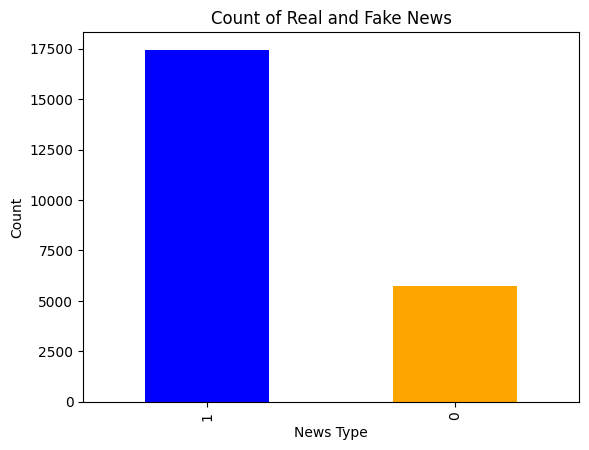

Real News Count: 17439
Fake News Count: 5754


In [52]:
# Show the count of real and fake news
df['real'].value_counts().plot(kind='bar', color=['blue', 'orange'], title='Count of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

# Print count of real and fake news
real_count = df['real'].sum()  # Count of real news (where 'real' is 1)
fake_count = len(df) - real_count  # Count of fake news
print(f"Real News Count: {real_count}")
print(f"Fake News Count: {fake_count}")

In [53]:
# Combine text features into one column
df['combined_text'] = df['title'] + ' ' + df['news_url'] + ' ' + df['source_domain']
y = df['real']

In [54]:
# Split data into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(df['combined_text'], y, test_size=0.3, random_state=101)

# Further split temp into test (20%) and validation (10%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=101)

In [55]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [56]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_vec_smote, y_train_smote = smote.fit_resample(X_train_vec, y_train)

In [57]:
# Define a basic logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the resampled training data
model.fit(X_train_vec_smote, y_train_smote)

LogisticRegression(max_iter=1000, random_state=42)

In [58]:
train_score = model.score(X_train_vec_smote, y_train_smote)
val_score = model.score(X_val_vec, y_val)
test_score = model.score(X_test_vec, y_test)

print("Train Score:", train_score)
print("Validation Score:", val_score)
print("Test Score:", test_score)

Train Score: 0.9821868330323428
Validation Score: 0.9473684210526315
Test Score: 0.959051724137931


In [59]:
print(f"Number of iterations to converge: {model.n_iter_}")

Number of iterations to converge: [47]


Validation Accuracy (LR Model): 0.9473684210526315
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       557
           1       0.96      0.97      0.97      1761

    accuracy                           0.95      2318
   macro avg       0.93      0.93      0.93      2318
weighted avg       0.95      0.95      0.95      2318



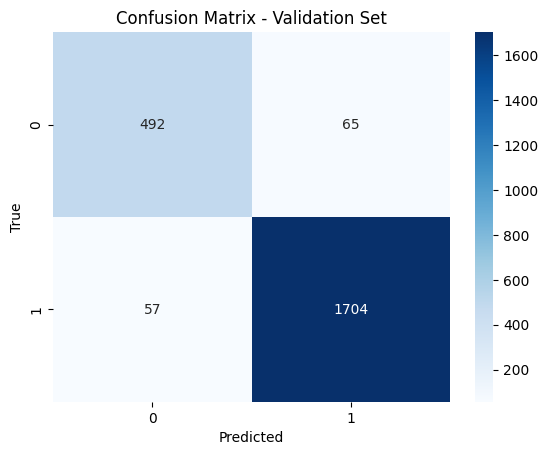

In [60]:
# Validate the logistic regression model
val_predictions = model.predict(X_val_vec)
val_accuracy = accuracy_score(y_val, val_predictions)
print("Validation Accuracy (LR Model):", val_accuracy)
print(classification_report(y_val, val_predictions))

# Confusion matrix for validation set
val_cm = confusion_matrix(y_val, val_predictions)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Test Accuracy (LR Model): 0.959051724137931
Test ROC-AUC Score (LR Model): 0.985480659214927
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1144
           1       0.97      0.98      0.97      3496

    accuracy                           0.96      4640
   macro avg       0.95      0.94      0.94      4640
weighted avg       0.96      0.96      0.96      4640



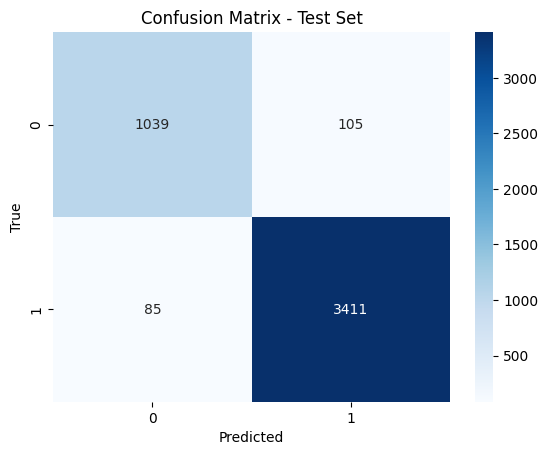

In [61]:
# Test the logistic regression model
test_predictions = model.predict(X_test_vec)
test_accuracy = accuracy_score(y_test, test_predictions)
test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_vec)[:, 1])
print("Test Accuracy (LR Model):", test_accuracy)
print("Test ROC-AUC Score (LR Model):", test_roc_auc)
print(classification_report(y_test, test_predictions))

# Confusion matrix for test set
val_cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Hyperparameter tuning on Logistic Regression Model

In [62]:
# Define the parameters for grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'solver': ['liblinear', 'lbfgs', 'newton-cg']  # Optimization algorithms
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=100000, random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,  # 5-fold cross-validation
                           verbose=1,
                           n_jobs=-1)  # Use all available CPU cores

In [63]:
# Perform grid search on the training data
grid_search.fit(X_train_vec_smote, y_train_smote)  # Use resampled training data for grid search

# Get the best parameters found by grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 10.0, 'solver': 'liblinear'}


Validation Accuracy (Tuned LR Model): 0.9749784296807593
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       557
           1       0.98      0.99      0.98      1761

    accuracy                           0.97      2318
   macro avg       0.97      0.96      0.97      2318
weighted avg       0.97      0.97      0.97      2318



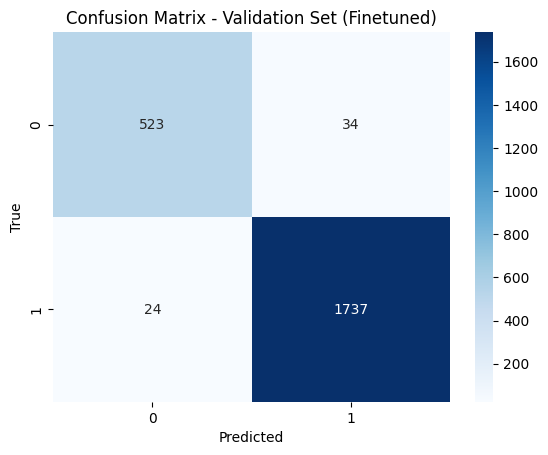

In [64]:
# Evaluate the model with best parameters on the validation set
best_model = grid_search.best_estimator_
val_predictions_tuned = best_model.predict(X_val_vec)
val_accuracy_tuned = accuracy_score(y_val, val_predictions_tuned)
print("Validation Accuracy (Tuned LR Model):", val_accuracy_tuned)
print(classification_report(y_val, val_predictions_tuned))

# Confusion matrix for validation set (Best Parameters)
val_cm = confusion_matrix(y_val, val_predictions_tuned)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set (Finetuned)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Test Accuracy (Tuned LR Model): 0.9799568965517241
Test ROC-AUC Score (Tuned LR Model): 0.9930697520442944
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1144
           1       0.98      0.99      0.99      3496

    accuracy                           0.98      4640
   macro avg       0.98      0.97      0.97      4640
weighted avg       0.98      0.98      0.98      4640



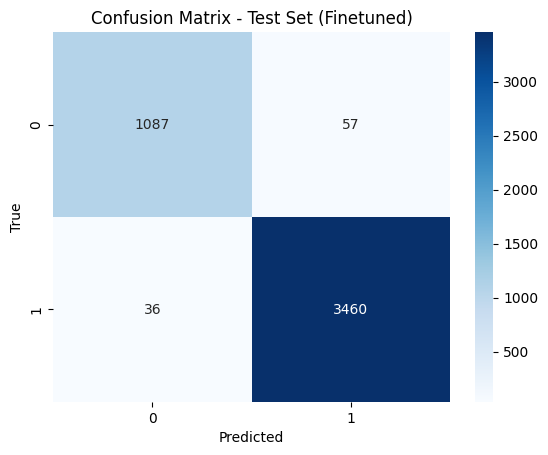

In [65]:
# Evaluate the model with best parameters on the test set
test_predictions_tuned = best_model.predict(X_test_vec)
test_accuracy_tuned = accuracy_score(y_test, test_predictions_tuned)
test_roc_auc_tuned = roc_auc_score(y_test, best_model.predict_proba(X_test_vec)[:, 1])
print("Test Accuracy (Tuned LR Model):", test_accuracy_tuned)
print("Test ROC-AUC Score (Tuned LR Model):", test_roc_auc_tuned)
print(classification_report(y_test, test_predictions_tuned))

# Confusion matrix for test set (Best Parameters)
val_cm = confusion_matrix(y_test, test_predictions_tuned)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set (Finetuned)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [66]:
# Predict custom input
custom_input = "gwen stefani got dumped by blake shelton jealousy and drama exclusive"
vectorized_input = vectorizer.transform([custom_input])
prediction = best_model.predict(vectorized_input)

# Print prediction result
print("Prediction for custom input:", "Real" if prediction[0] == 1 else "Fake")

Prediction for custom input: Fake


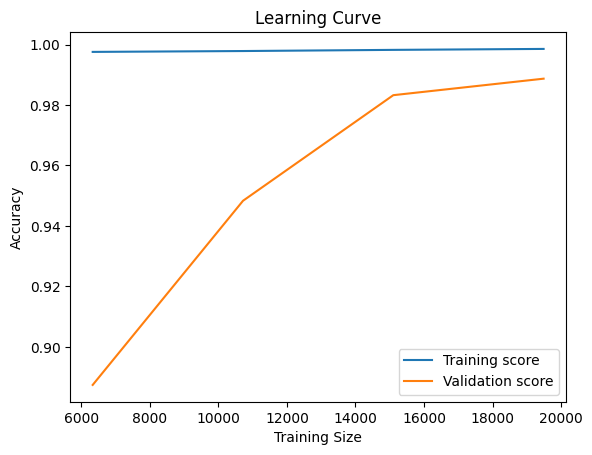

In [67]:
# Plot training vs validation score
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_vec_smote, y_train_smote, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, val_scores_mean, label='Validation score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()